# Course Project: Bike Sharing Demand Prediction with Python and PySpark
- FOR I535 FA21: MGMT ACCESS USE BIG DATA

## Introduction
My project title is “Bike Sharing Demand Prediction with Python and PySpark”. The dataset I used for this project is from https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset. This dataset contains the Capital bike sharing data between 2011 and 2012 (original source: http://capitalbikeshare.com/system-data) as well as the corresponding holiday schedule (http://dchr.dc.gov/page/holiday-schedule), weather and seasonal information (http://www.freemeteo.com). There are two separate csv files saving in the dataset. One is named as ‘day.csv’, presenting daily based bike rental information. The other file is ‘hour.csv’, presenting hourly based rental information. One of the objectives is to predict the bike rental count on hourly basis using a series of important features as presented in the dataset. Hence, this is a regression problem. The results may help improving the bike sharing system management and services.

Another objective is to compare the process and results with Python and PySpark. Two machine learning models, including simple linear regression and decision trees, were constructed in both Python and PySpark analysis. I mainly applied the knowledge of virtualization, data lifecycle & pipeline as well as distributed processing I have learned from this class for the project. A virtual machine is created on JetStream (https://jetstream-cloud.org/). The whole data lifecycle and pipeline from data integration to publication is detailed illustrated in the main body of the project based on the USGS model. The results are finally published to github (https://github.com/zhaoy426/I535FA21BIGDATAFP).

## Background
A bike sharing system exists all over the world [1]. It provides a convenient, healthy, fun, environment friendly way for everyone to transport around cities by rental bicycles. In the system, people can borrow a bicycle from one docking station and easily return to another. In big city, like Washington DC, you can ride to work, to have a local tour using a rental bicycle without worrying about traffic jam or finding a parking lot while driving a car. Users usually pay with a membership or a credit/debit card. We call the users paying with a membership as ‘registered’ users, while other users are ‘casual’. The real-time data of (http://capitalbikeshare.com/system-data) is updated monthly, with clear information on start time, end time, duration, start station, end station, bike number and user member type. However, to build machine learning (ML) model, we need to integrate other relevant information to accurately predict rental count at a given time. Weather and season are usually considered as important factors to drive people whether to ride a bike. In addition, whether a day is a weekday or weekend, or holiday also indirectly affect bike rental count. Unfortunately, I could not find a free recent weather dataset online. Hence, I chose the bike sharing data published on UCI machine learning repository. This dataset is well documented capital bike sharing information as well as weather, season, and holiday features. The analysis with historical data will provide a method for any bike sharing data collected within another timeline. The results may be useful to improve the bike sharing system management and services. For example, the information may be used in a bike rental app to allow users to see traffic trend. The manager can use it to decide how many bikes should be supplied in a specific docking station.

For my personal interest, I would like to use both Python and PySpark to build the ML models. PySpark is a new technology to me. It is attractive because it does parallel processing, similar to MapReduce. Learning use of PySpark will be useful for analyzing big data. The analysis with Python will be considered as baseline to compare with.

## Methodology
I will follow the USGS data pipeline to introduce the methodology.

### 1. Technological Setup
All the work is conducted on JetStream (https://jetstream-cloud.org/), a cloud-based computing platform for researchers. First, I created a project named “I535-Spark-Project”, and then created an instance with the image of ‘Pyspark-Ubuntu18_04-instance’ with small size (m1.small (CPU: 2, Mem: 4 GB, Disk: 20 GB)) under the project. This image contains python3, java8, scala, spark3, hadoop and jupyter notebook pre-installed for I535 Assignment. Following the class instruction of “Analyzing data with PySpark” [2], I setup the computing environment (Fig 1). In addition, I also installed matplotlib, seaborn using pip3 for data visualization.

Picture1.png

Fig 1. Terminal code for setup: 1) Verify Spark installation; 2) Copy the .bashrc file; 3) "Load" the .bashrc file; 4) Verify Java, Scala and Python3 version/installation; 5) Confirm that Spark uses Python 3; 6) Export two additional environment variables for Spark: local IP and master; 7) Install jupyter notebook; 8) Install py4j; 9) Launch jupyter notebook.

### 2. Data Ingestion
The capital bikesharing dataset in zipped CSV format was downloaded from UCI machine learning repository (http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) using Python code. Then the dataset was extracted to two csv data files (day.csv and hour.csv) and one “ReadMe” text file. There are 15 and 16 columns in ‘day’ and ‘hour’ data file, respectively. Fifteen common columns exist in both data files. The ‘hour’ data has one more variable - ‘hour’ (see more details in the notebook). For Python analysis, both day.csv and hour.csv were read into pandas DataFrame, while for PySpark analysis, day.csv was read in and transformed to RDD using textFile() and SparkContext.

#### Ingest dataset

In [31]:
from urllib.request import urlopen
from zipfile import ZipFile

zipurl = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip'
    # Download the file from the URL
zipresp = urlopen(zipurl)
    # Create a new file on the hard drive
tempzip = open("/tmp/tmpfile.zip", "wb")
    # Write the contents of the downloaded file into the new file
tempzip.write(zipresp.read())
    # Close the newly-created file
tempzip.close()
    # Re-open the newly-created file with ZipFile()
zf = ZipFile("/tmp/tmpfile.zip")
    # Extract its contents into <extraction_path>
    # note that extractall will automatically create the path
zf.extractall(path = '/home/zhaoy426/FP/data/')
    # close the ZipFile instance
zf.close()

Create a Spark dataframe using the CSV file

### Data description
The following columns are included in the dataset:

#### Index column:
- instant: record index

#### Feature columns:
- dteday: date
- season: season (1:spring, 2:summer, 3:fall, 4:winter)
- yr: year (0:2011, 1:2012)
- mnth: month (1 to 12)
- hr: hour (0 to 23)
- holiday: 1 if holiday, 0 otherwise
- weekday: day of the week (0 to 6)
- workingday: 0 if weekend or holiday, 1 otherwise
- weathersit: (1:clear, 2:mist or clouds, 3:light rain or snow, 4:heavy rain or snow)
- temp: normalized temperature in Celsius
- atemp: normalized feeling temperature in Celsius
- hum: normalized humidity
- windspeed: normalized wind speed

#### Label columns:
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

## Part 1: ML with Python

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
import time

In [33]:
# convert day.csv file to DataFrame and check data information
day = pd.read_csv('/home/zhaoy426/FP/data/day.csv')
day.head()
day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [34]:
# convert hour.csv file to DataFrame and check data information
hour = pd.read_csv('/home/zhaoy426/FP/data/hour.csv')
hour.head()
hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


### 3. Data Processing
#### 1) Data visualization for Exploratory Data Analysis (EDA) 
Data visualization was performed with Python. First, I examined the data information to see each column name, data type and missing values. Since this dataset has no missing values, there is no need to handle with missing values. The next step is to explore correlations between each two variables. Heatmap is used to identify high correlations. Then box plots or bar plots are used to show the variation and distribution among the subgroups of categorical variables (e.g., season, year, months, holiday, weekday, weather conditions). Histograms are used to show the distribution for numeric independent variables as well as the target variable – total rental count.

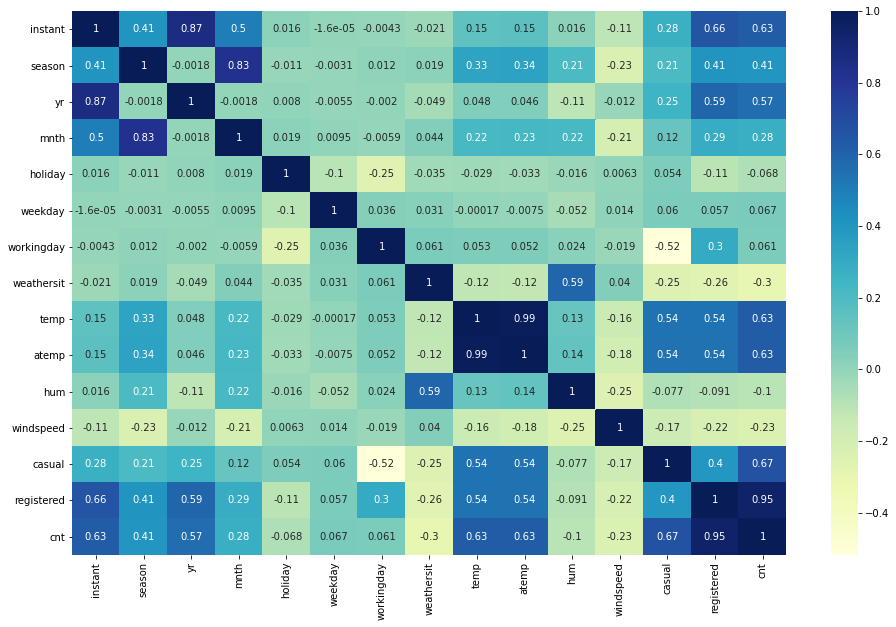

In [35]:
# Draw heatmaps
plt.figure(figsize = (16, 10))
sns.heatmap(day.corr(), annot = True, cmap="YlGnBu")
plt.show()

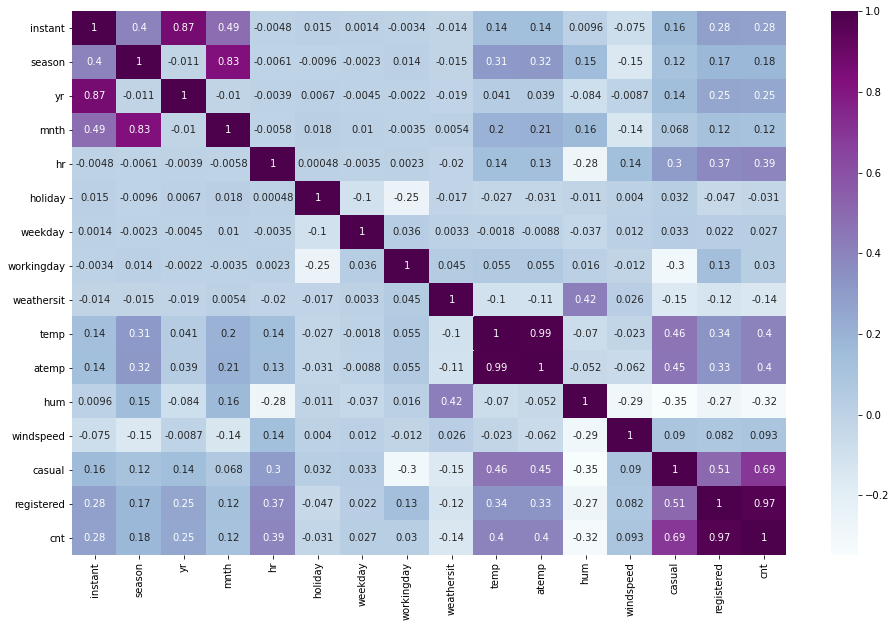

In [36]:
# Draw heatmap with hour data - Fig 2.
plt.figure(figsize = (16, 10))
sns.heatmap(hour.corr(), annot = True, cmap="BuPu")
plt.show()

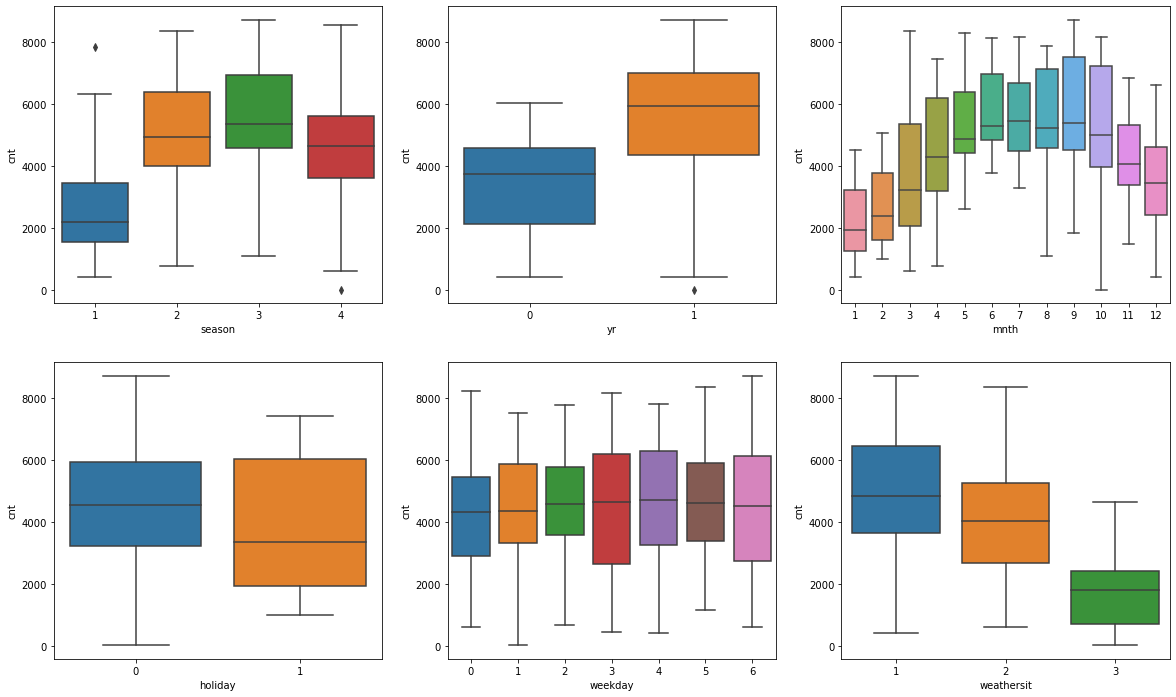

In [37]:
### Draw box plots for categorical variables
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = day)
plt.subplot(2,3,2)
sns.boxplot(x = 'yr', y = 'cnt', data = day)
plt.subplot(2,3,3)
sns.boxplot(x = 'mnth', y = 'cnt', data = day)
plt.subplot(2,3,4)
sns.boxplot(x = 'holiday', y = 'cnt', data = day)
plt.subplot(2,3,5)
sns.boxplot(x = 'weekday', y = 'cnt', data = day)
plt.subplot(2,3,6)
sns.boxplot(x = 'weathersit', y = 'cnt', data = day)
plt.show()

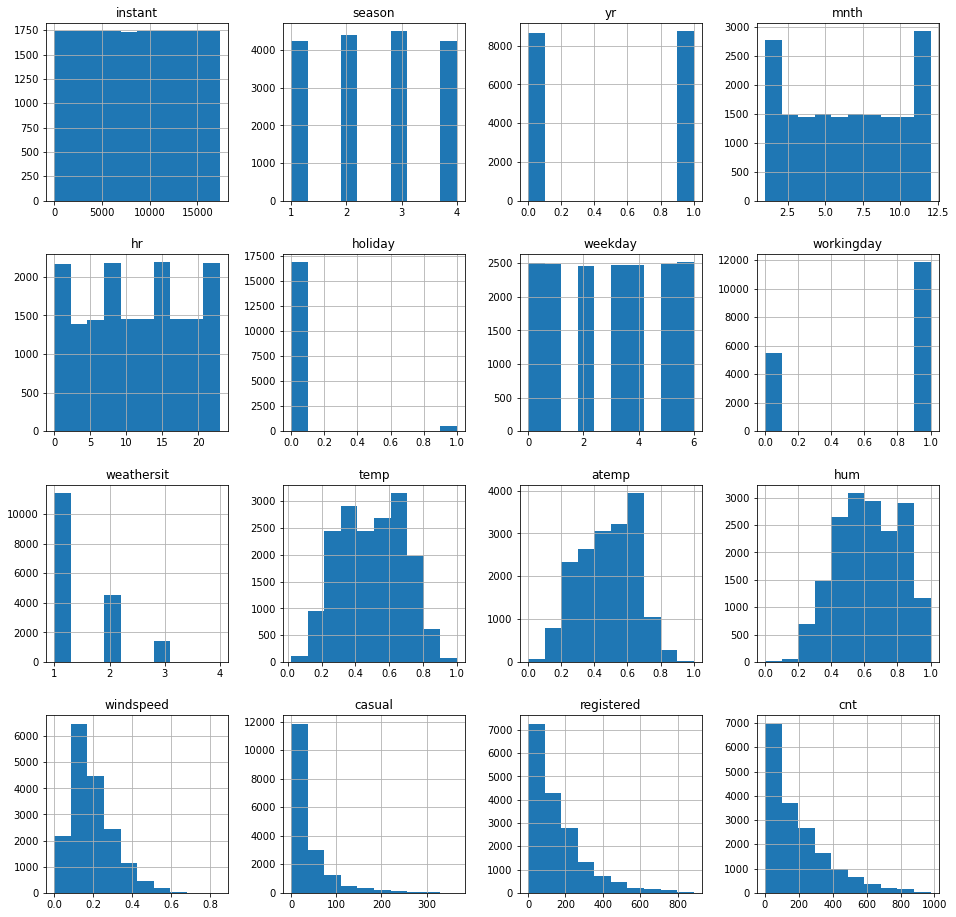

In [38]:
# Draw histograms for continuious variables and bar charts for categorical variables
plt.rcParams['figure.figsize'] = (16,16)
hour.hist()
plt.show()

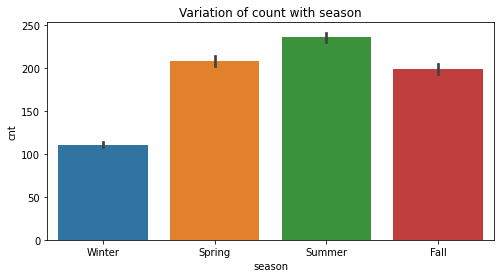

In [39]:
# Total rental count grouped by season
plt.figure(figsize=(8,4))
ax = sns.barplot(data=hour, x="season", y="cnt")
ax.set_title('Variation of count with season')

tick_val=[0,1, 2, 3]
tick_lab=['Winter', 'Spring', 'Summer', 'Fall']
plt.xticks(tick_val, tick_lab)
plt.show()

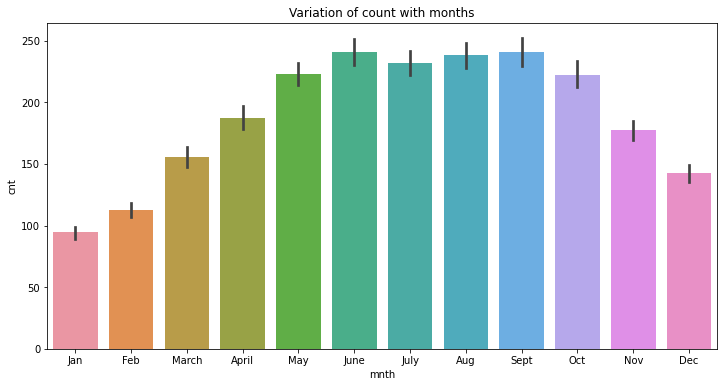

In [40]:
# Total rental count grouped by month
plt.figure(figsize=(12,6))
ax = sns.barplot(x='mnth', y='cnt', data=hour)
ax.set_title('Variation of count with months')
sns.set(style="whitegrid")

tick_val=[0,1 , 2, 3, 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11]
tick_lab=['Jan','Feb','March','April','May','June','July','Aug','Sept','Oct','Nov','Dec']
plt.xticks(tick_val, tick_lab)
plt.show()

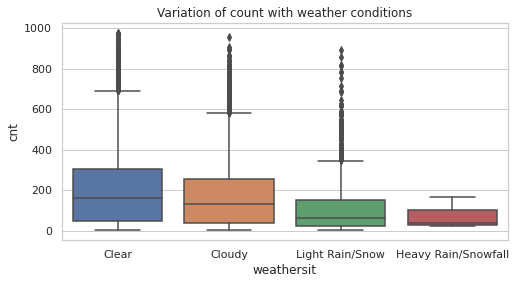

In [41]:
# Total rental count grouped by weather conditions
plt.figure(figsize=(8,4))
ax = sns.boxplot(data=hour, x="weathersit", y="cnt")
ax.set_title('Variation of count with weather conditions')

tick_val=[0,1, 2, 3]
tick_lab=['Clear', 'Cloudy', 'Light Rain/Snow','Heavy Rain/Snowfall']
plt.xticks(tick_val, tick_lab)
plt.show()

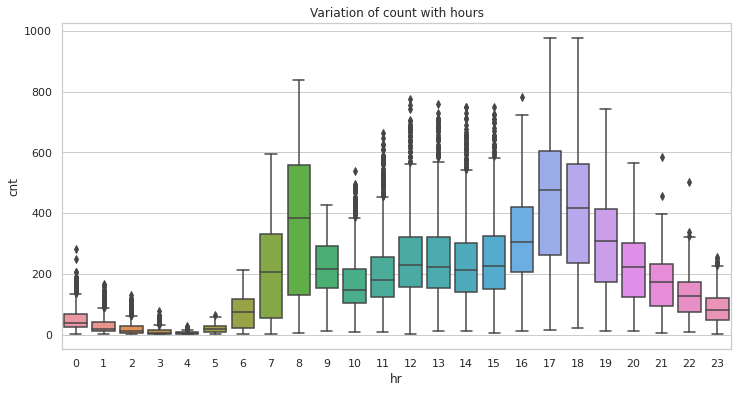

In [42]:
# Total rental count grouped by hour
plt.figure(figsize=(12,6))
ax = sns.boxplot(x='hr', y='cnt', data=hour)
ax.set_title('Variation of count with hours')
sns.set(style="whitegrid")

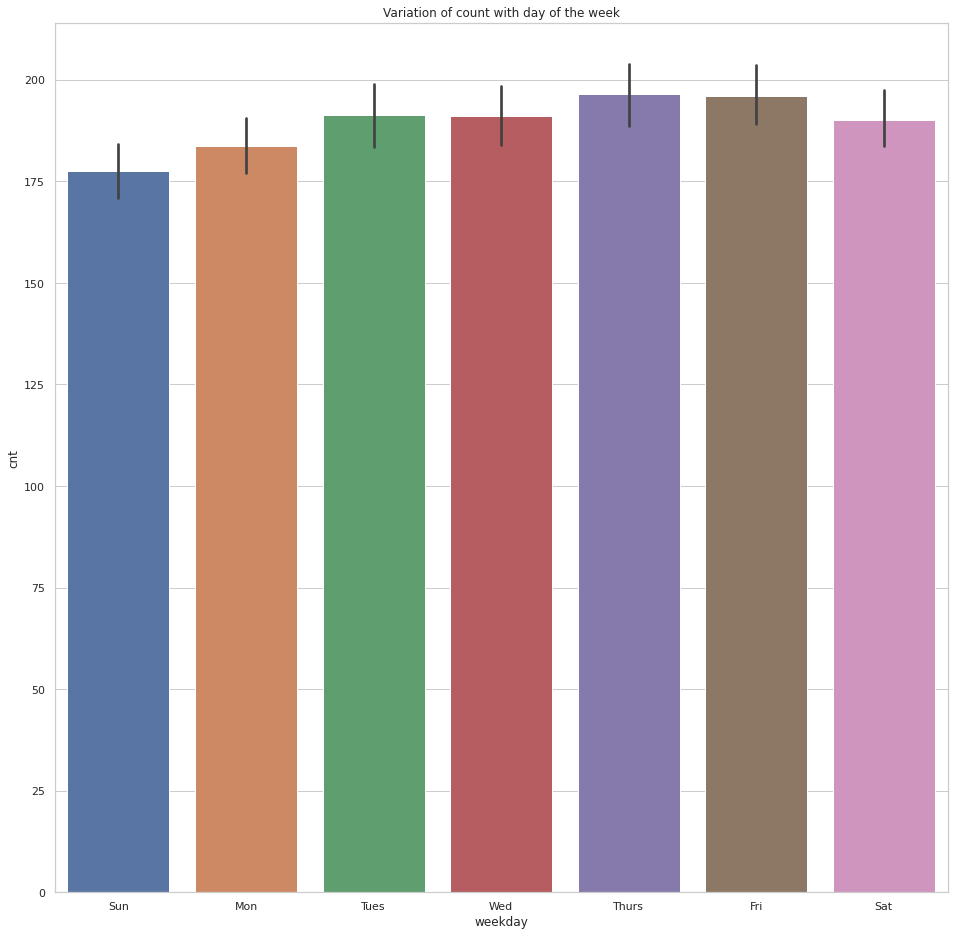

In [43]:
# total rental count grouped by weekday
ax = sns.barplot(x="weekday",y='cnt',data=hour)
ax.set_title('Variation of count with day of the week')
tick_val=[0, 1, 2, 3, 4, 5, 6]
tick_lab=['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat']
plt.xticks(tick_val, tick_lab)
plt.show()

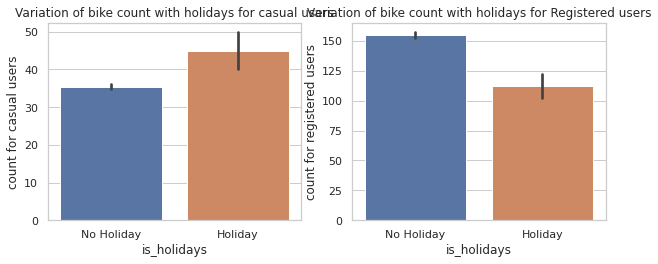

In [44]:
# casual user count / registered user count changes with holiday
plt.figure(figsize=(10,8))
plt.subplot(2, 2, 1)
ax = sns.barplot(x="holiday",y='casual',data=hour)
plt.xlabel("is_holidays")
plt.ylabel("count for casual users")
ax.set_title('Variation of bike count with holidays for casual users')

tick_val=[0,1]
tick_lab=['No Holiday','Holiday']
plt.xticks(tick_val, tick_lab)

plt.subplot(2, 2, 2)
ax = sns.barplot(x="holiday",y='registered',data=hour)
plt.xlabel("is_holidays")
plt.ylabel("count for registered users")
ax.set_title('Variation of bike count with holidays for Registered users')

tick_val=[0,1]
tick_lab=['No Holiday','Holiday']
plt.xticks(tick_val, tick_lab)
plt.show()

/home/zhaoy426/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cnt', ylabel='Density'>

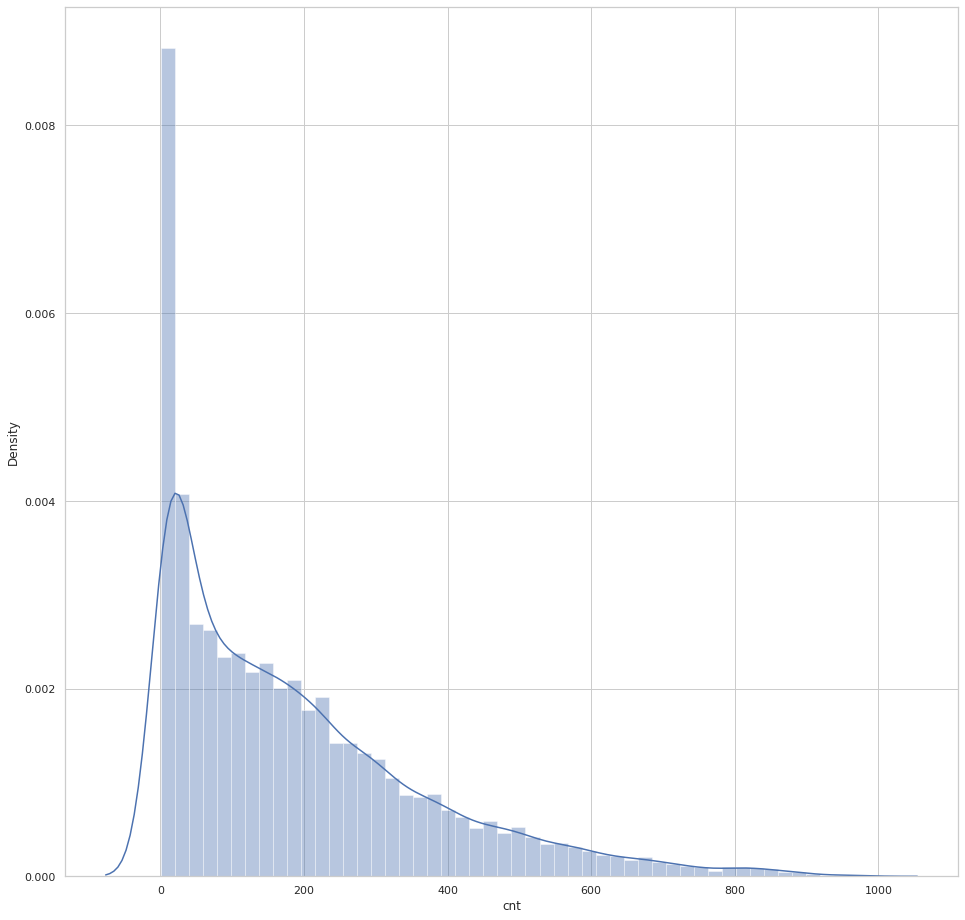

In [45]:
# Check target distribution: Count column looks skew.
sns.distplot(hour['cnt'])

In [46]:
# Take a log for count column
hour['cnt'] = np.log1p(hour['cnt'])

/home/zhaoy426/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cnt', ylabel='Density'>

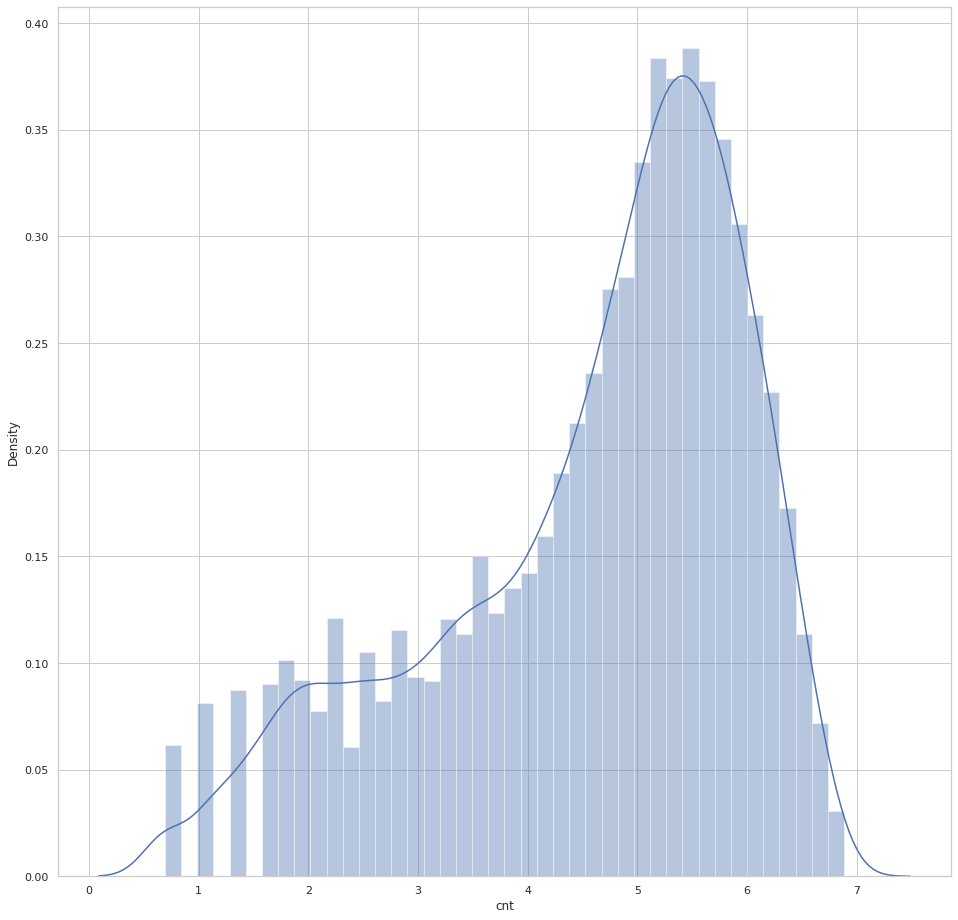

In [47]:
sns.distplot(hour['cnt'])

In [48]:
print(hour.head())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered       cnt  
0           1  0.24  0.2879  0.81        0.0       3          13  2.833213  
1           1  0.22  0.2727  0.80        0.0       8          32  3.713572  
2           1  0.22  0.2727  0.80        0.0       5          27  3.496508  
3           1  0.24  0.2879  0.75        0.0       3          10  2.639057  
4           1  0.24  0.2879  0.75        0.0       0           1  0.693147  


#### 2) Feature Engineering
For Python analysis, 11 features were selected for model construction based on the EDA results. They are temperature, humidity, windspeed, hour, weekday, month, year, season, holiday, weather condition and working day. Among them, season, holiday, weather condition and working day features were encoded with one-hot-encoding strategy. Target was also transformed using preprocessing.LabelEncoder(). 
In PySpark analysis, linear regression needs categorical features to be expressed as binary vector form (like one-hot encoding). Hence, I extracted the unique values of each categorical feature and mapped them to a unique index using zipWithIndex() function [3]. Then the categorical features (column 2-8) were converted to binary-encoded form, while the numeric variables (column 10-13) were converted to floating numbers. Since decision tree can directly work with raw features, I simply converted all features to floating numbers for decision tree modeling. 



#### Feature Engineering

In [49]:
# Renaming columns names to more readable names
hour.rename(columns={'instant':'rec_id',
                        'dteday':'datetime',
                        'holiday':'is_holiday',
                        'workingday':'is_workingday',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_count',
                        'hr':'hour',
                        'yr':'year'},inplace=True)

###########################
# Setting proper data types
###########################
# date time conversion
hour['datetime'] = pd.to_datetime(hour.datetime)

# categorical variables
hour['season'] = hour.season.astype('category')
hour['is_holiday'] = hour.is_holiday.astype('category')
hour['weekday'] = hour.weekday.astype('category')
hour['weather_condition'] = hour.weather_condition.astype('category')
hour['is_workingday'] = hour.is_workingday.astype('category')
hour['month'] = hour.month.astype('category')
hour['year'] = hour.year.astype('category')
hour['hour'] = hour.hour.astype('category')

In [50]:
# Defining categorical variables encoder method
def fit_transform_ohe(df,col_name):
    """This function performs one hot encoding for the specified
column.
    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        col_name: the column to be one hot encoded
    Returns:
        tuple: label_encoder, one_hot_encoder, transformed column as pandas Series
    """
    # label encode the column
    le = preprocessing.LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name+'_label'] = le_labels
    # one hot encoding
    ohe = preprocessing.OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    return le,ohe,features_df

# given label encoder and one hot encoder objects, 
# encode attribute to ohe
def transform_ohe(df,le,ohe,col_name):
    """This function performs one hot encoding for the specified
        column using the specified encoder objects.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        le(Label Encoder): the label encoder object used to fit label encoding
        ohe(One Hot Encoder): the onen hot encoder object used to fit one hot encoding
        col_name: the column to be one hot encoded

    Returns:
        tuple: transformed column as pandas Series

    """
    # label encode
    col_labels = le.transform(df[col_name])
    df[col_name+'_label'] = col_labels
    
    # ohe 
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return features_df

In [51]:
# Divide the dataset into training and testing sets
X, X_test, y, y_test = train_test_split(hour.iloc[:,0:-3],
                                        hour.iloc[:,-1],
                                        test_size=0.2,
                                        random_state=42)
X.reset_index(inplace=True)
y = y.reset_index()

X_test.reset_index(inplace=True)
y_test = y_test.reset_index()

In [52]:
# Encoding all the categorical features
cat_attr_list = ['season','is_holiday',
                 'weather_condition','is_workingday',
                 'hour','weekday','month','year']
# though we have transformed all categoricals into their one-hot encodings, note that ordinal
# attributes such as hour, weekday, and so on do not require such encoding.
numeric_feature_cols = ['temp','humidity','windspeed',
                        'hour','weekday','month','year']
subset_cat_features =  ['season','is_holiday','weather_condition','is_workingday']

###############
# Train dataset
###############
encoded_attr_list = []
for col in cat_attr_list:
    return_obj = fit_transform_ohe(X,col)
    encoded_attr_list.append({'label_enc':return_obj[0],
                              'ohe_enc':return_obj[1],
                              'feature_df':return_obj[2],
                              'col_name':col})


feature_df_list  = [X[numeric_feature_cols]]
feature_df_list.extend([enc['feature_df'] \
                        for enc in encoded_attr_list \
                        if enc['col_name'] in subset_cat_features])

train_df_new = pd.concat(feature_df_list, axis=1)
print("Train dataset shape::{}".format(train_df_new.shape))
print(train_df_new.head())

##############
# Test dataset
##############
test_encoded_attr_list = []
for enc in encoded_attr_list:
    col_name = enc['col_name']
    le = enc['label_enc']
    ohe = enc['ohe_enc']
    test_encoded_attr_list.append({'feature_df':transform_ohe(X_test,
                                                              le,ohe,
                                                              col_name),
                                   'col_name':col_name})
    
    
test_feature_df_list = [X_test[numeric_feature_cols]]
test_feature_df_list.extend([enc['feature_df'] \
                             for enc in test_encoded_attr_list \
                             if enc['col_name'] in subset_cat_features])

test_df_new = pd.concat(test_feature_df_list, axis=1) 
print("Test dataset shape::{}".format(test_df_new.shape))
print(test_df_new.head())

Train dataset shape::(13903, 19)
   temp  humidity  windspeed hour weekday month year  season_1  season_2  \
0  0.20      0.55     0.2239   11       6     1    0       1.0       0.0   
1  0.52      0.42     0.1045   18       2    10    0       0.0       0.0   
2  0.46      1.00     0.2239    3       3    12    0       0.0       0.0   
3  0.46      0.31     0.0000   18       0     4    0       0.0       1.0   
4  0.20      0.75     0.1045    6       0    12    0       1.0       0.0   

   season_3  season_4  is_holiday_0  is_holiday_1  weather_condition_1  \
0       0.0       0.0           1.0           0.0                  1.0   
1       0.0       1.0           1.0           0.0                  1.0   
2       0.0       1.0           1.0           0.0                  0.0   
3       0.0       0.0           1.0           0.0                  0.0   
4       0.0       0.0           1.0           0.0                  1.0   

   weather_condition_2  weather_condition_3  weather_condition_4 

#### 3) Modeling
The hour data was split into training set and testing set with a ratio of 8:2. Linear regression and decision tree methods were used for modeling with both Python and PySpark. The fit time was calculated and recorded. Hyperparameter tuning with GridSearch was performed to fully optimize selected model(s). 


#### Modeling

In [53]:
# Constructing train dataset
X = train_df_new
y= y.total_count.values.reshape(-1,1)

# Constructing test dataset
X_test = test_df_new
y_test = y_test.total_count.values.reshape(-1,1)
print(X.shape,y.shape)

(13903, 19) (13903, 1)


#### Linear Regression

#### 4) Model Evaluation and Comparison
The performance of ML models was evaluated with R squred, mean squared error (MSE), mean absolute error (MAE) and root mean squared log error (RMSLE). 


In [55]:
# calculate linear regression fit time and evaludate model performance 
startTime1 = time.time()

linearRegressor = LinearRegression()
linearRegressor.fit(X, y)
 
duration1 = time.time() - startTime1

y_predicted = linearRegressor.predict(X_test)
mse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)
mae = mean_absolute_error(y_test,y_predicted)
rmsle = np.sqrt(mean_squared_log_error(y_test, y_predicted))

print("Mean Squared Error:",mse)
print("R squared score:",r2)
print("Mean Absolute Error:",mae)
print('RMSLE: ', rmsle)
print()
print('Fit duration time for liear regression model is :', duration1)

Mean Squared Error: 1.0011882142444333
R squared score: 0.49147861482493826
Mean Absolute Error: 0.7894450670217972
RMSLE:  0.22854511131149743

Fit duration time for liear regression model is : 0.6457703113555908


#### Decision Tree

In [64]:
# calculate decision tree fit time and evaludate model performance 
startTime2 = time.time()

dtm = DecisionTreeRegressor(max_depth=5,
                           min_samples_split=5,
                           max_leaf_nodes=10)

dtm.fit(X,y)
duration2 = time.time()-startTime2



dtm.fit(X_test,y_test)  
y_predicted = dtm.predict(X_test)
mse = mean_squared_error(y_test, y_predicted)
mae = mean_absolute_error(y_test,y_predicted)
rmsle = np.sqrt(mean_squared_log_error(y_test, y_predicted))

print("R-Squared in train data={}".format(dtm.score(X,y)))
print("R-Squared in test data={}".format(dtm.score(X_test,y_test)))
print("MSE in test data: ", mse)
print('MAE in test data: ', mae)
print('RMSLE in test data: ', rmsle)
print('Fit time', duration2)

R-Squared in train data=0.7267995602920961
R-Squared in test data=0.7330409197863536
MSE in test data:  0.525594975132512
MAE in test data:  0.5584150015986287
RMSLE in test data:  0.1557756098729682
Fit time 0.14822864532470703


In [57]:
extracted_MSEs = dtm.tree_.impurity # The Hidden magic is HERE

rmse_total=0
mse_total=0
for idx, MSE in enumerate(dtm.tree_.impurity):
    rmse_total = rmse_total + np.sqrt(MSE)
    mse_total = mse_total + MSE
    print("Node {} has MSE {}".format(idx,MSE))
#print('RMSE: ', rmse_total/len(dtm.tree_.impurity))
print('MSE: ', mse_total/len(dtm.tree_.impurity))

Node 0 has MSE 1.9688222431387743
Node 1 has MSE 1.1345558417507933
Node 2 has MSE 0.7768711895422555
Node 3 has MSE 0.8301696099350622
Node 4 has MSE 0.5073893322080565
Node 5 has MSE 0.7908843849119656
Node 6 has MSE 0.8668879016189122
Node 7 has MSE 0.35443724229995155
Node 8 has MSE 0.652212018975959
Node 9 has MSE 0.8689190301497902
Node 10 has MSE 0.6825462710152834
Node 11 has MSE 0.46265014905697655
Node 12 has MSE 0.5686012659476152
Node 13 has MSE 1.0082132033122058
Node 14 has MSE 0.6529701348010093
Node 15 has MSE 0.31223237159141615
Node 16 has MSE 0.47231798303401895
Node 17 has MSE 0.5387400235313748
Node 18 has MSE 0.3844043153702206
MSE:  0.7280960269574548


High performance model will be selected for hyper-parameter tuning with grid search. Then the new model will be evaluated.

#### Decision Tree is selected for hyper-parameter tuning

In [65]:
# This may take some time...
startTime_cv = time.time()
param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100]
              }


grid_cv_dtm = GridSearchCV(dtm, param_grid, cv=5)

grid_cv_dtm.fit(X,y)
duration_cv = time.time() - startTime_cv

print('Time for grid search: ', duration_cv)

Time for grid search:  1725.5123522281647


In [59]:
print("R-Squared::{}".format(grid_cv_dtm.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_dtm.best_params_))

R-Squared::0.8827411902044228
Best Hyperparameters::
{'criterion': 'mae', 'max_depth': 8, 'max_leaf_nodes': 100, 'min_samples_leaf': 20, 'min_samples_split': 10}


In [60]:
df = pd.DataFrame(data=grid_cv_dtm.cv_results_)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.037338,0.045068,0.004258,0.000695,mse,2,5,20,10,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.647159,0.641736,0.640449,0.650763,0.655476,0.647117,0.005596,117
1,0.011743,0.000282,0.003479,0.000118,mse,2,5,20,20,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.647159,0.641736,0.640449,0.650763,0.655476,0.647117,0.005596,117
2,0.012045,0.000408,0.003594,0.000290,mse,2,5,20,40,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.647159,0.641736,0.640449,0.650763,0.655476,0.647117,0.005596,117
3,0.011947,0.000221,0.003430,0.000099,mse,2,5,40,10,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.647159,0.641736,0.640449,0.650763,0.655476,0.647117,0.005596,109
4,0.012101,0.000227,0.003443,0.000085,mse,2,5,40,20,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.647159,0.641736,0.640449,0.650763,0.655476,0.647117,0.005596,109


In [61]:
# Checking the training model scores
r2_scores = cross_val_score(grid_cv_dtm.best_estimator_, X, y, cv=10)
mse_scores = cross_val_score(grid_cv_dtm.best_estimator_, X, y, cv=10,scoring='neg_mean_squared_error')

print("avg R-squared::{:.3f}".format(np.mean(r2_scores)))
print("MSE::{:.3f}".format(np.mean(mse_scores)))

avg R-squared::0.884
MSE::-0.234


### Test dataset evaludatioin

In [63]:
best_dtm_model = grid_cv_dtm.best_estimator_

y_pred = best_dtm_model.predict(X_test)
residuals = y_test.flatten() - y_pred


r2_score_dt = best_dtm_model.score(X_test,y_test)
mae_dt = mean_absolute_error(y_test,y_pred)
rmsle_dt = np.sqrt(mean_squared_log_error(y_test, y_pred))
print("R-squared for the best DT model:{:.3f}".format(r2_score_dt))
print("MSE: %.3f" % metrics.mean_squared_error(y_test, y_pred))
print('MAE: %.3f' %mae_dt)
print('RMSLE: %.3f' %rmsle_dt)

R-squared for the best DT model:0.883
MSE: 0.231
MAE: 0.340
RMSLE: 0.112


## Part 2: Analyze data with PySpark

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext()
spark = SparkSession(sc)
from pyspark import *                                                                                                               


#df = spark.read.csv("/home/zhaoy426/FP/data/hour.csv", header="true", inferSchema="true")
# The following command caches the DataFrame in memory. This improves performance since subsequent calls to the DataFrame can read from memory instead of re-reading the data from disk.
#df.cache()

In [2]:
# read data and save header in a different file
rawdata = sc.textFile ('/home/zhaoy426/FP/data/hour.csv')
header = rawdata.first()
print(header)

instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt


In [3]:
# delete the header line in 'hour' data
rdata = rawdata.filter(lambda x: x!=header)
print(rdata)

PythonRDD[3] at RDD at PythonRDD.scala:53


In [4]:
# check the first five rows
print(rdata.take(5))

['1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0,3,13,16', '2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.8,0,8,32,40', '3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.8,0,5,27,32', '4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0,3,10,13', '5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0,0,1,1']


In [5]:
# splite the rows by comma
records = rdata.map(lambda x: x.split(','))
first = records.first()
print('The dataset has '+str(records.count())+' rows.')

The dataset has 17379 rows.


In [6]:
records.cache()

PythonRDD[7] at RDD at PythonRDD.scala:53

In PySpark analysis, linear regression needs categorical features to be expressed as binary vector form (like one-hot encoding). Hence, I extracted the unique values of each categorical feature and mapped them to a unique index using zipWithIndex() function [3]. Then the categorical features (column 2-8) were converted to binary-encoded form, while the numeric variables (column 10-13) were converted to floating numbers. Since decision tree can directly work with raw features, I simply converted all features to floating numbers for decision tree modeling. 

In [7]:
def get_mapping(rdd, idx):
    return rdd.map(lambda fields: fields[idx]).distinct().zipWithIndex().collectAsMap()

In [8]:
print ("Mapping of first categorical feasture column: %s" % get_mapping(records, 2))

Mapping of first categorical feasture column: {'1': 0, '4': 1, '2': 2, '3': 3}


In [9]:
mappings = [get_mapping(records, i) for i in range(2,10)]
cat_len = sum(map(len, mappings))
num_len = len(records.first()[11:15])
total_len = num_len + cat_len

In [10]:
print ("Feature vector length for categorical features: %d" % cat_len)
print ("Feature vector length for numerical features: %d" % num_len)
print ("Total feature vector length: %d" % total_len)

Feature vector length for categorical features: 57
Feature vector length for numerical features: 4
Total feature vector length: 61


#### Creating feature vectors for the linear model
Use previous extracted mappings to convert the categorical features to binary-encoded features.

In [11]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

In [12]:
def extract_features(record):
    cat_vec = np.zeros(cat_len)
    i = 0
    step = 0
    for field in record[2:9]:
        m = mappings[i]
        idx = m[field]
        cat_vec[idx + step] = 1
        i = i + 1
        step = step + len(m)
    num_vec = np.array([float(field) for field in record[10:14]])
    return np.concatenate((cat_vec, num_vec))

In [13]:
def extract_label(records):
    return float(records[-1])

In [14]:
data = records.map(lambda r: LabeledPoint(extract_label(r), extract_features(r)))

#### Split train & Test Data

In [15]:
#data_log = records.map(lambda r: LabeledPoint(np.log(extract_label(r)), extract_features(r)))

In [16]:
train_test_data_split = data.randomSplit([0.8, 0.2],42)

train = train_test_data_split[0]
test = train_test_data_split[1]
print("Training set size is: ", train.count())
print("Test set size is : ", test.count())

Training set size is:  13953
Test set size is :  3426


In [17]:
first_point = train.first()
print ("Training data: " + str(first[2:]))
print ("Label: " + str(first_point.label))
print ("Linear Model feature vector:\n" + str(first_point.features))
print ("Linear Model feature vector length: " + str(len(first_point.features)))

Training data: ['1', '0', '1', '0', '0', '6', '0', '1', '0.24', '0.2879', '0.81', '0', '3', '13', '16']
Label: 16.0
Linear Model feature vector:
[1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.24,0.2879,0.81,0.0]
Linear Model feature vector length: 61


#### Creating feature vectors for the decision tree
Decision tree models typically work on raw features, so we converts all the values to floats and wraps them in a numpy array.

In [18]:
def extract_features_dt(record):
    #return np.array(map(float, record[2:14]))
    return np.array([float(field) for field in record[2:14]])

In [19]:
data_dt = records.map(lambda r: LabeledPoint(extract_label(r),extract_features_dt(r)))
train_test_data_dt_split = data_dt.randomSplit([0.8, 0.2],123)
train_dt = train_test_data_dt_split[0]
test_dt = train_test_data_dt_split[1]
print('Training data size for DT: ', train_dt.count())
print('Test data size for DT: ', test_dt.count())

first_point_dt = train_dt.first()
print ("Decision Tree feature vector: " + str(first_point_dt.features))
print ("Decision Tree feature vector length: " + str(len(first_point_dt.features)))

Training data size for DT:  13878
Test data size for DT:  3501
Decision Tree feature vector: [1.0,0.0,1.0,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.8,0.0]
Decision Tree feature vector length: 12


### Training and using regression models
Pass the training data contained in a [LabeledPoint] RDD to the relevant train method.  

In [20]:
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.tree import DecisionTree
#help(LinearRegressionWithSGD.train)

In [21]:
#help(DecisionTree.trainRegressor)

### Training a regression model on the bike sharing dataset

In [22]:
import time
startTime = time.time()

linear_model = LinearRegressionWithSGD.train(train, iterations=10,step=0.1, intercept=True,)

duration = time.time() - startTime
print('It takes ', round(duration, 3), 's for training a regression model.')

It takes  5.197 s for training a regression model.


In [23]:
train_true_vs_predicted = train.map(lambda p: (p.label, linear_model.predict(p.features)))
test_label_vs_predicted = test.map(lambda p: (p.label, linear_model.predict(p.features)))
print ("Linear Model predictions with Training data: " + str(train_true_vs_predicted.take(5)))
print ("Linear Model predictions with Test data: " + str(test_label_vs_predicted.take(5)))

Linear Model predictions with Training data: [(16.0, 133.7774532372653), (40.0, 132.32035348341907), (32.0, 132.15404948065805), (13.0, 131.86616131251571), (1.0, 131.6927055917107)]
Linear Model predictions with Test data: [(14.0, 139.83822691798082), (56.0, 143.5933194270156), (110.0, 148.43177785930908), (37.0, 150.46621866199337), (34.0, 146.07859120445653)]


### Train the decision tree model

In [24]:
startTime_dt = time.time()

dt_model = DecisionTree.trainRegressor(train_dt,{},maxDepth=5, maxBins=32)


duration_dt = time.time() - startTime_dt
print('It takes ', round(duration, 3), 's for training a Decision Tree model.')

train_preds = dt_model.predict(train_dt.map(lambda p: p.features))
train_actual = train_dt.map(lambda p: p.label)
train_true_vs_predicted_dt = train_actual.zip(train_preds)

test_preds = dt_model.predict(test_dt.map(lambda p: p.features))
test_actual = test_dt.map(lambda p: p.label)
test_true_vs_predicted_dt = test_actual.zip(test_preds)
print ("Decision Tree predictions: " + str(train_true_vs_predicted_dt.take(5)))
print ("Decision Tree depth: " + str(dt_model.depth()))
print ("Decision Tree number of nodes: " + str(dt_model.numNodes()))

It takes  5.197 s for training a Decision Tree model.
Decision Tree predictions: [(40.0, 56.71707317073171), (32.0, 52.88333333333333), (13.0, 14.6672760511883), (1.0, 14.6672760511883), (1.0, 14.6672760511883)]
Decision Tree depth: 5
Decision Tree number of nodes: 63


### Evaluating the performance of regression models

In [25]:
from pyspark.mllib.evaluation import RegressionMetrics

def MSE(model, data):
    predict = model.predict(data.map(lambda p:p.features))
    predict_real = predict.zip(data.map(lambda p:p.label))
    #rmse = np.sqrt(predict_real.map(lambda p: (p[0] - p[1])**2).sum() / predict_real.count())
    mse = predict_real.map(lambda p: (p[0] - p[1])**2).sum() / predict_real.count()
    return mse

def MAE(model, data):
    predict = model.predict(data.map(lambda p:p.features))
    predict_real = predict.zip(data.map(lambda p:p.label)) 
    mae = (predict_real.map(lambda p: np.abs(p[0] - p[1]))).mean()
    return mae

# root mean squre log error
def RMSLE(model, data):
    predict = model.predict(data.map(lambda p:p.features))
    predict_real = predict.zip(data.map(lambda p:p.label)) 
    rmsle = (predict_real.map(lambda p: (np.log(p[0]+1) - np.log(p[1]+1))**2)).mean()
    return rmsle

def metrics(model, data):
    #predict = model.predict(data.map(lambda p: p.features))
    #predict_real = predict.zip(data.map(lambda p:p.label)) 
    #metrics = RegressionMetrics(predict_real)
    #r2=metrics.r2
    predictions_observations = data \
                      .map(lambda p : (float(model.predict(p.features)), p.label)).cache()
    r2 = RegressionMetrics(predictions_observations).r2
    return r2

def dt_r2(model, data):
    predict = model.predict(data.map(lambda p:p.features))
    predictions_observations = predict.zip(data.map(lambda p:p.label))
    r2 = RegressionMetrics(predictions_observations).r2
    return r2


In [26]:
r2 = metrics(linear_model, train)
mse = MSE(linear_model, train)
mae = MAE(linear_model, train)
rmsle = RMSLE(linear_model, train)

print('Linear Model - R squared in training data: %2.4f' %r2)
print('Linear Model - Mean Squared Error in training data: %2.4f' %mse)
print('Linear Model - Mean Absolute Error in training data: %2.4f' %mae)
print('Linear Model - Root Mean Squared Log Error in training data: %2.4f' %rmsle)

Linear Model - R squared in training data: 0.0828
Linear Model - Mean Squared Error in training data: 30358.7810
Linear Model - Mean Absolute Error in training data: 132.7895
Linear Model - Root Mean Squared Log Error in training data: 2.2375


In [27]:
r2 = metrics(linear_model, test)
mse = MSE(linear_model, test)
mae = MAE(linear_model, test)
rmsle = RMSLE(linear_model, test)

print('Linear Model - R squared: %2.4f' %r2)
print('Linear Model - Mean Squared Error in Test data: %2.4f' %mse)
print('Linear Model - Mean Absolute Error in Test data: %2.4f' %mae)
print('Linear Model - Root Mean Squared Log Error in Test data: %2.4f' %rmsle)

Linear Model - R squared: 0.0863
Linear Model - Mean Squared Error in Test data: 29305.0559
Linear Model - Mean Absolute Error in Test data: 131.5691
Linear Model - Root Mean Squared Log Error in Test data: 2.3192


### Evaluating the performance of Decision Tree models

In [28]:
r2 = dt_r2(dt_model, test_dt)
mse = MSE(dt_model, test_dt)
mae = MAE(dt_model, test_dt)
rmsle = RMSLE(dt_model, test_dt)


print('Decision Tree - R squared: %2.4f' %r2)
print('Decision Tree - Mean Squared Error in Test data: %2.4f' %mse)
print('Decision Tree - Mean Absolute Error in Test data: %2.4f' %mae)
print('Decision Tree - Root Mean Squared Log Error in Test data: %2.4f' %rmsle)

Decision Tree - R squared: 0.6401
Decision Tree - Mean Squared Error in Test data: 11637.7830
Decision Tree - Mean Absolute Error in Test data: 71.1915
Decision Tree - Root Mean Squared Log Error in Test data: 0.3860


### 4. Data Storage
A new volume was created to save the dataset, metadata and program under the Project in JetStream. 

### 5. Data Sharing
The dataset, metadata and program were published to github https://github.com/zhaoy426/I535FA21BIGDATAFP.

## Results

### 1. Exploratory Data Analysis (EDA)
This dataset has no missing values. From heatmaps, I spotted high correlations between count of registered uses and total rental count, moderate positive correlations between year/temperature/season and user count, negative correlation between windspeed and casual user count. There could be some non-linear relationships between a feature and the target. Therefore, using boxplots, histograms or bar charts will be useful to identify the variation, distribution, and trends as well. From boxplots, you can easily see how the environmental variables affect bike rental count. In general, the more pleasant weather is, the more bike riders would be. There are more bike users in summer and fall seasons from May to October. From hour-based box plot, you can see a bimodal-like distribution. One peak occurred in morning at start work time, and the other occurred in the evening at off-work time.  Weekday has some influence on the number of bike users. Sunday has the least bike users. Holiday attracts more casual users. Non-holiday has more registered users. The distribution of target variable is skewed towards lower values. After log transformation, the shape is close to a normal distribution, but still has skewness (left-skewed). 

### 2. ML Model Performance
R2, MSE, MAE, RMSLE were used to evaluate ML models (Table 1). A total of 13903 with Python and 13953 observations (80% of total sample size) with PySpark were random selected for constructing ML models. Linear regression model was constructed as a baseline ML to compare with. Decision Tree (DT) shows higher accuracy as compared to linear regression model in both Python and PySpark analysis. DT model constructed with pure Python performs the best in the first run using 80% training set, with R2 = 0.73, MSE = 0.53, MAE = 0.56 and RMSLE = 0.16 (Table not shown). Hence, I conducted grid search for hyperparameter tuning to improve its prediction accuracy.  The parameter settings in grid search are shown as following: 
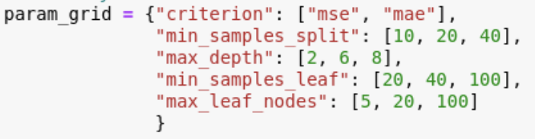



After 5 cross-validations, the best parameters were selected as ‘criterion’ = ‘mae’, ‘min_samples_split’ = 10, ‘max_depth’ = 8, ‘min_samples_leaf’ = 20, ‘max_leaf_nodes’ = 100. Then I used the best parameters to run 10 cross-validations and got an average R2 = 0.88 and MSE = 0.23 on training set. The performance was also evaluated with testing set. The results are shown in Table 1.

Table 1. Performance Comparison for Different ML Models

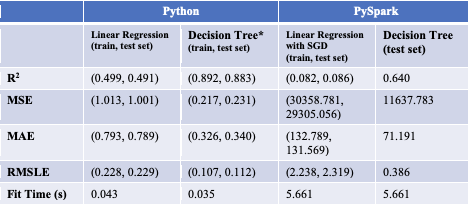
Note: 
Fit time is based on a single run with 80% training set. 
The performance results, including R2, MSE and MAE, for DT model with Python are based on the best hyperparameters selected from GridSearch CV. 
Target values are transformed with Python, thus the MSE, MAE, RMSLE are much lower compared to those with PySpark.


The linear regression with SGD built with PySpark has extremely low R2 and very high MSE and MAE, leading to poor prediction on bike rental count. DT with PySpark has moderate R2 value, but MSE, MAE are not good enough. By contrast, the linear regression model constructed with Python has moderate R2. The values of MSE, MAE and RMSLE are acceptable. DT with Python is the only model has potential to accurate predict bike rental count.

In terms of fit time, it is interesting to see the models running with Python took less time (about 0.04s) compared to PySpark (about 5.66s). There is no much difference between linear regression and DT models.  The time using for grid search with Python is relatively long, taking about 29 min.

## Discussion

### 1. Technology Deployment
All the work was conducted on a virtual machine built on JetStream, which is a platform designed for science community. I chose JetStream as my working platform, because I like the user-selectable preconfigured VM instances it provides and the desktop operation makes it easier to learn and use. Although it does not support High Performance Computing (HPC), the resource it allocates is enough for me to do analysis with small data.

Another technology I used in this project is distributed processing with Spark. Spark does in-memory calculations and works with RDDs, which can contain any type of data [5]. With RDD, big data can be chunked into many small pieces and distributed to a cluster of nodes. Thus, Spark has the capacity to quickly do iterative tasks [6]. In addition, Spark can perform batch processing similar to MapReduce. PySpark for making it possible to run Spark in Python environment. I am a beginner in Spark. Running a real problem with PySpark is a good opportunity for me to learn how to use PySpark code and also improve my understanding on how distributed processing works.

### 2. Data Interpretation
The EDA results reveal that the majority of bike sharing users are ‘registered’ users. They usually transport to and from work with rental bikes. Therefore, you see less rental count during the work hours, weekend, or holidays. While ‘casual’ users are more likely to ride a bike on weekend and holidays for fun. However, season and weather conditions will affect their transportation choice. It is easily to understand that people are less likely to ride a bike when temperature is low or extremely high, when there is a heavy rain or snow.

The target variable does not show normal distribution, probably producing heterogeneity of variance. The target was transformed in Python analysis, but not in PySpark. In the next step, I will think about transform target and re-build the models with PySpark. Some efforts have been made to run regression models with log-transformed targets with PySpark. However, the transformation did not improve the models [4]. Will try to use a different transformation method to improve model accuracy.


### 3. Model Performance with Python and PySpark
Since target has been rescaled with Python, the MSE, MAE and RMSLE may not be comparable with the results generated by PySpark. But we can still see the current model accuracy in PySpark is not high. There are multiple ways to improve the model accuracy, for examples, try a different ML model, perform grid search to select a set of best hyperparameters, etc. On the other hand, it should be aware of overfitting issues. Hence, in the future analysis, penalty parameters should be added into the models. 

I chose PySpark as a technology to build ML models, because Spark has many advantages for big data processing. I was expected to see the model fit time with PySpark is shorter than that with pure Python. However, the results are different from my expectation. WHY? I did some investigations online and found that it is common Python is faster than PySpark when working with small operations, because when python processes a simple task on single core, it does not need any overhead, whereas Spark first distributes chunks of data into a cluster of nodes, then processes it with MapReduce methods, in which lots of overhead is needed for small operations [7-8]. Therefore, Spark is more suitable for processing large data, but if the data is small, it may not outperform while running a single process on a single machine [8].

### 4. Data lifecycle and Pipeline
I would like to match my data pipeline with the USGS model I have learned from this class (Fig 4). My data pipeline can be summarized as data capture, data processing and data sharing as shown below. Initially, I acquired the capital bike sharing data published on UCI data repository. The data in UCI was originally derived from http://capitalbikeshare.com/system-data, http://dchr.dc.gov/page/holiday-schedule and http://www.freemeteo.com. UCI must have its own pipeline from data capture to data sharing as well. But for me, my data capture step starting from loading data. To prepare data importation, I setup a VM on JetStream and created an instance with the image of ‘Pyspark-Ubuntu18_04-instance’, which contains the necessary tools I will need for my analysis. After setup, data was able to read into the program for data processing. This step includes data visualization, vibrable transformation, build ML models and finally data storage. At last, the data and results are published on Github. Each point of the data lifecycle can find a match in the pipeline (Fig 5). Setup can match with plan, since what you chose to setup depends on your plan. For other stages in pipeline, data import can match with “Acquire” in lifecycle. Feature selection or data transformation can be considered as “Process” stage. Construction of ML models matches with “Analyze” stage. At last, storing files on cloud and creating publicly accessible URL can match with “Preserve” and “Publish/Share” stages, respectively. 
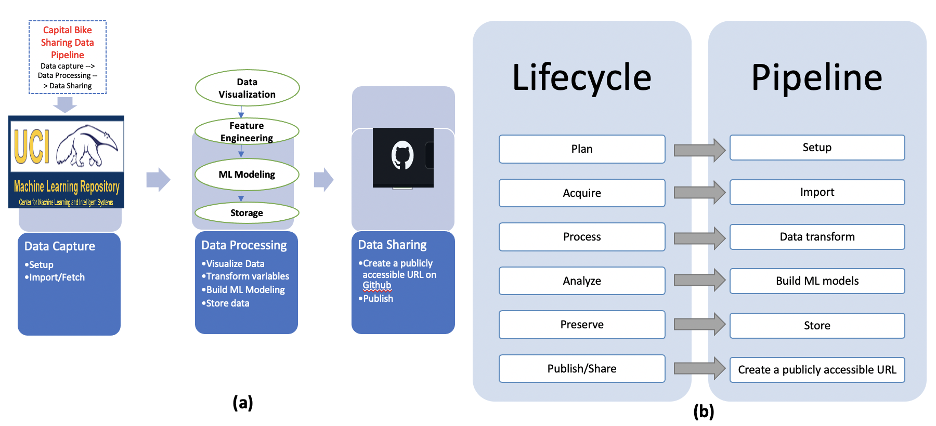


### 5. Challenges
I have encountered barriers when I ran the PySpark code. The reference code I used did not work out at some point, for example, when I used labeledPoint() function and calculated the model accuracy. I performed some investigations online and finally found solutions. It is a good opportunity to learn more about PySpark. 

## Conclusion

This project uses Capital bike sharing data from UCI data repository to construct ML models for bike rental count prediction with both Python and PySpark. The project was conducted following a planned data pipeline from data capture to data sharing. All calculation work with Python and PySpark was performed on a JetStream VM. The Decision Tree model built with Python performs best with high R2 and low MSE values. The accuracy for the DT model was further improved by grid search. Grid search will be performed for the DT model with PySpark in next step. The model fit time with Python was less than that with PySpark, indicating PySpark is not competitive with Python when running simple tasks with small data. Results and data were finally published on Github, and also stored in cloud for future use. 

## References

1. What Is Bike Sharing? How Bike-Share Programs Work, Pros & Cons. https://www.moneycrashers.com/bike-sharing-best-bike-share-programs/. 

2. Class notebook. https://iu.instructure.com/courses/1999601/assignments/12257378?module_item_id=24231479.
3. Bike Sharing Demand Kaggle Competition with Spark and Python. http://analyticsclassroom.blogspot.com/2016/07/bike-sharing-demand-kaggle-competition.html. 
4. Extracting Features from the Bike Sharing Dataset https://notebook.community/PacktPublishing/Machine-Learning-with-Spark/Chapter-06/.ipynb_checkpoints/Machine%20Learning%20with%20Spark,%20Chapter%206-checkpoint.
 
5. Big Data Processing with Apache Spark? Part 1: Introduction. https://www.infoq.com/articles/apache-spark-introduction/. 

6. Exploring the Evolution of Big Data Technologies. https://www.sciencedirect.com/topics/computer-science/resilient-distributed-dataset. 

7.  pyspark performance vs pure python doing simple sum.
https://stackoverflow.com/questions/61811453/pyspark-performance-vs-pure-python-doing-simple-sum.

8. Spark cluster does not scale to small data. https://stackoverflow.com/questions/43372296/spark-cluster-does-not-scale-to-small-data. 

9. Python reference codes:
https://www.kaggle.com/tboyle10/capital-bikeshare-exploratory-analysis; 
https://github.com/shaw-anugya/Bike-Sharing-Demand/blob/master/Bike%20Sharing%20Demand.ipynb;
https://www.kaggle.com/marklvl/decision-tree-regressor-on-bike-sharing-dataset. 

10. PySpark reference codes:
https://blog.csdn.net/u013719780/article/details/51822346; 
https://notebook.community/PacktPublishing/Machine-Learning-with-Spark/Chapter-06/.ipynb_checkpoints/Machine%20Learning%20with%20Spark,%20Chapter%206-checkpoint; 
https://docs.databricks.com/_static/notebooks/gbt-regression.html. 